# Analyze and plot repetition code memory experiment data

In [30]:
from typing import Dict, List

import collections
import itertools
import functools

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif", "font.size": 16})
import numpy as np
import pickle

import cirq
import qiskit

## Helper functions

In [2]:
def get_counts_for(qubit: int, counts: collections.Counter[str, int]) -> collections.Counter[int, int]:
    qubit_counts = collections.Counter()
    for key, value in counts.items():
        k = list(key)[qubit]
        qubit_counts[int(k)] += value
    return qubit_counts


def generate_stabilizer_elements(generators: List[cirq.PauliString]) -> List[cirq.PauliString]:
    elements = []
    for string in itertools.chain.from_iterable(itertools.combinations(generators, r) for r in range(len(generators) + 1)):
        elements.append(
            functools.reduce(lambda a, b: a * b, string, cirq.PauliString())
        )
    return elements


def compute_expectation(
    pauli: cirq.PauliString,
    counts: Dict[str, int],
) -> float:
    if pauli is cirq.PauliString():
        return 1.0

    expectation = 0.0

    indices = [q.x for q in pauli.qubits]
    for key, value in counts.items():
        key = list(map(int, list(key)))
        expectation += (-1) ** sum([key[i] for i in indices]) * value

    return expectation / sum(counts.values())

## Load data

In [3]:
# Set data directory (job id).
job_id = "ctwgnt7seb10008x520g"

In [4]:
nqubits = int(np.loadtxt(f"{job_id}/nqubits.txt"))
depths = [int(d) for d in np.loadtxt(f"{job_id}/depths.txt")]
nvals = [int(n) for n in np.loadtxt(f"{job_id}/nvals.txt")]
physical_qubits = [int(q) for q in np.loadtxt(f"{job_id}/physical_qubits.txt")]
nshots = int(np.loadtxt(f"{job_id}/nshots.txt"))

try:
    # Save format prior to SamplerV2 / PrimitiveResultV2 / Qiskit V48745 nonsense.
    with open(f"{job_id}/{job_id}.pkl", "rb") as f:
        result = qiskit.result.Result.from_dict(pickle.load(f))
    all_counts = result.get_counts()
except:
    all_counts = []
    for depth in depths:
        with open(f"{job_id}/depth_{depth}_counts.pkl", "rb") as f:
            all_counts.append(pickle.load(f))

## Visualize physical results

In [53]:
expectations = {q: [] for q in range(nqubits)}

for counts in all_counts:  # Loop over circuit depth.
    for qubit in expectations.keys():
        qubit_counts = get_counts_for(qubit, counts)
        expectations[qubit].append(
            (qubit_counts.get(0) - qubit_counts.get(1)) / nshots
        )

expectations = {q: np.array(v) for q, v in expectations.items()}
all_expectations = np.array([v for _, v in expectations.items()])

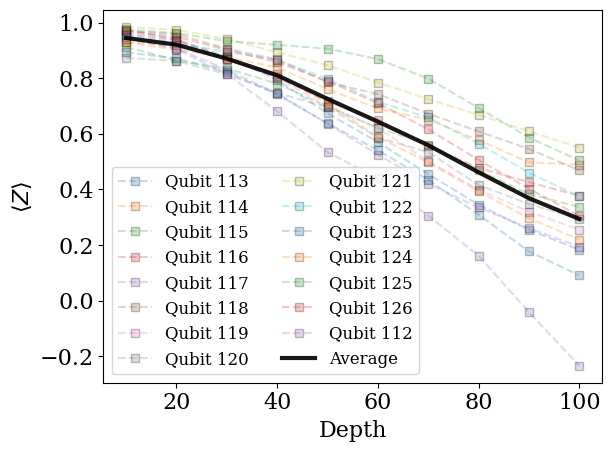

In [67]:
for qubit, expectation in expectations.items():
    plt.plot(depths, expectation, "--s", label=f"Qubit {physical_qubits[qubit]}", alpha=0.25, mec="black")

plt.xlabel("Depth")
plt.ylabel(r"$\langle Z \rangle$")
plt.plot(
    depths,
    np.average(all_expectations, axis=0),
    color="black",
    lw=3,
    alpha=0.90,
    label="Average",
);
plt.legend(ncol=2);
plt.tight_layout()
plt.savefig(f"{job_id}_physical.pdf")

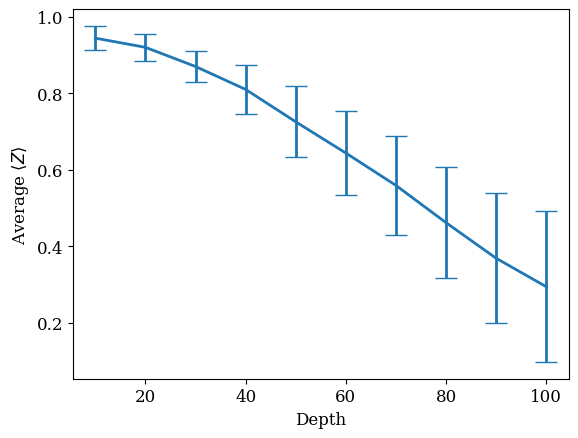

In [7]:
all_expectations = np.array([v for _, v in expectations.items()])

plt.errorbar(
    x=depths,
    y=np.average(all_expectations, axis=0),
    yerr=np.std(all_expectations, axis=0, ddof=1),
    capsize=8,
    lw=2,
)

plt.xlabel("Depth")
plt.ylabel(r"Average $\langle Z \rangle$");


## Post-processing

In [8]:
# # Post-process by applying the codespace projector directly. Note that for this experiment this equivalent to the (much) faster post-processing by post-selection below.
# all_lst_values = {}

# for n in nvals:
#     print(f"Post-processing status: n = {n}")
#     q = cirq.LineQubit.range(n)
#     observable = cirq.Z.on(q[0])
#     generators = [
#         cirq.Z.on(q[i]) * cirq.Z.on(q[i + 1]) for i in range(len(q) - 1)
#     ]
#     elements = generate_stabilizer_elements(generators)
#     paulis = [observable * p for p in elements]
#     lst_values = []

#     for counts in all_counts:
#         denominator = sum(
#             compute_expectation(e, counts) for e in elements
#         ) / 4.0
#         numerator = sum(
#             compute_expectation(p, counts) for p in paulis
#         ) / 4.0
#         lst_values.append(numerator / denominator)

#     print(lst_values)
#     all_lst_values[n] = lst_values

In [9]:
# Post-process by post-selection.
all_lst_values = {}

for n in nvals:
    print(f"Post-processing status: n = {n}")
    post_selection_values = [] = []

    for counts in all_counts:
        subselected = collections.Counter()
        for k, v in counts.items():
            subselected[k[:n]] += v

        num_zero = subselected.get("0" * n, 0)
        num_one   = subselected.get("1" * n, 0)

        total = num_zero + num_one
        eval = (num_zero - num_one) / total
        post_selection_values.append(eval)

    all_lst_values[n] = post_selection_values

Post-processing status: n = 3
Post-processing status: n = 5
Post-processing status: n = 7
Post-processing status: n = 9
Post-processing status: n = 11
Post-processing status: n = 13
Post-processing status: n = 15


## Plotting

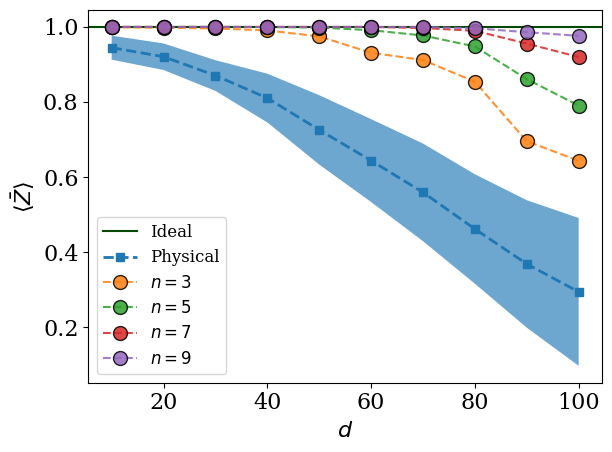

In [ ]:
# Plot average physical expectation values.
plt.rc("font", size=16)
plt.rc("legend", fontsize=12)
plt.axhline(
    y=1.0,
    label="Ideal",
    color="xkcd:darkgreen",
)
plt.plot(
    depths,
    np.average(all_expectations, axis=0),
    "--s",
    lw=2,
    label="Physical",
)
plt.fill_between(
    x=depths,
    y1= np.average(all_expectations, axis=0) - np.std(all_expectations, axis=0, ddof=1),
    y2 = np.average(all_expectations, axis=0) + np.std(all_expectations, axis=0, ddof=1),
    alpha=0.65,
)

# Plot LST expectation values.
for n, lst_values in all_lst_values.items():
    if n <= 9:
        plt.plot(depths, lst_values, "--o", markersize=10, label=f"$n = {n}$", alpha=0.85, mec="black")

# Format.
plt.xlabel("$d$")
plt.ylabel(r"$\langle \bar{Z} \rangle$")
plt.legend();
plt.tight_layout();
# plt.savefig(f"{job_id}_d.pdf")

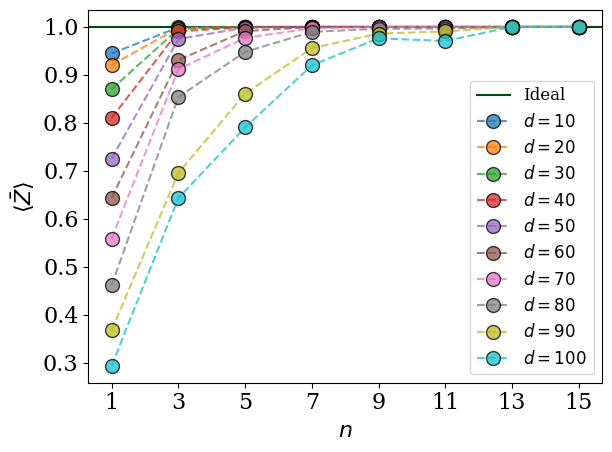

In [65]:
physical_averages = list(np.average(all_expectations, axis=0))

plt.axhline(
    y=1.0,
    label="Ideal",
    color="xkcd:darkgreen",
)

lst_vals = np.array([v for _, v in all_lst_values.items()]).T
for i, vals in enumerate(lst_vals):
    plt.plot([1] + list(nvals), [physical_averages[i]] + list(vals), "--o", label=f"$d = {depths[i]}$", markersize=10, mec="black", alpha=0.75)


plt.xticks(np.arange(1, max(nvals) + 1, 2))
# plt.yscale("log")
plt.xlabel("$n$")
plt.ylabel(r"$\langle \bar{Z} \rangle$")
plt.legend();
plt.tight_layout();
# plt.savefig(f"{job_id}_n.pdf")